# Joining Data

In [9]:
import pandas as pd
import numpy as np 
data_cell= pd.read_csv('cell_phones_total.csv')
data_pop =pd.read_csv('pop_data.csv')

# print(data_cell.iloc[:, 0] )

In [10]:
# here we clean the cell phone and population data

# temporarily remove first column of cellphone data
f=data_cell.iloc[:, 0]
#print(f)

data2 = data_cell.iloc[:, 1:]

# Remove rows with all missing data
data_popf2 = data_pop.loc[~(data_pop.iloc[:, 2:].fillna(0) == 0).all(axis=1)]
data_popf2 = data_popf2.drop(data_popf2.columns[0], axis=1)
# function that removes last symbol and changes value to the right value
def convert(value):
    if pd.isna(value):  
        return np.nan
    if isinstance(value, str):
        value = value.lower().strip()
        if value.endswith('k'):
            return float(value[:-1]) * 1e3 # change to float and multiply with the right amount
        elif value.endswith('m'):
            return float(value[:-1]) * 1e6
        elif value.endswith('b'):
            return float(value[:-1]) * 1e9       
        return None  
    return value  

# call function with all values (applymap)
data_cell2=data2.applymap(convert) 

# fill missing values to the right with the previous number, phones are assumed to be the same as the 
# last data point. 
data_cell2.iloc[:, 0:] = data_cell2.iloc[:, 0:].ffill(axis=1)

# Now convert all NaN cell data to 0
data_cell2 = data_cell2.fillna(0)

# merge string code with cleaned data for cellphones
data_cell_mf = pd.concat([f, data_cell2], axis=1) 


# data_cell_mf
# ata_popf2.head()

In [3]:
# Here i use the melt function, keeping the column "iso-3" frozen in place, while pivoting the column names 1960-2019 to a
# new column named year. The New column name is population. Equivalently done for cellphones 

m_p = pd.melt(data_popf2, id_vars=['iso-3'], var_name='year', value_name='population') 
m_c = pd.melt(data_cell_mf, id_vars=['iso-3'], var_name='year', value_name='n_cellphones') 

# Here we merge the two pivoted tables and aligned based on "iso-3" and "year"
merged = pd.merge(m_c, m_p, on=["iso-3", "year"], how="outer")

# Presented table
merged.head()


,iso-3,year,n_cellphones,population
0,ABW,1960,0.0,54608.0
1,AFG,1960,0.0,8622466.0
2,AGO,1960,0.0,5357195.0
3,ALB,1960,0.0,1608800.0
4,AND,1960,0.0,9443.0


In [11]:
# retieve additional data

data_name =pd.read_csv('country_data.csv')
# extract relavnt columns
data_name2=data_name[['name','alpha-3']]

data_name2.head()

,name,alpha-3
0,Afghanistan,AFG
1,Åland Islands,ALA
2,Albania,ALB
3,Algeria,DZA
4,American Samoa,ASM


In [5]:
# create new column
merged['cell/pop']=merged['n_cellphones']/merged['population']

# sort data as population and extract relevant columns
phone_pop = merged[['iso-3', 'cell/pop', 'year']] # 'name'

# rename to merge data and align to the same column
data_name2 = data_name2.rename(columns={"alpha-3": "iso-3"})

# merge name file with population data
merged2 = pd.merge(data_name2 , phone_pop, on="iso-3", how="right")

# lets drop column cellphone and population 
#merged2.drop(['n_cellphones', 'population','iso-3'], axis=1, inplace=True)

# drop country code
merged2.drop(['iso-3'], axis=1, inplace=True) 
# drop all rows with NaN values that we couldnt place
merged2 = merged2.dropna(subset=['name'])

# pivot dataphrame by country name 
pivot2 = merged2.pivot(index='year', columns='name', values='cell/pop')

# retrieve the wanted countries 
present=pivot2[['Macao','Hong Kong','United Arab Emirates','Antigua and Barbuda','Seychelles']]
present2 = present.iloc[:-1,:] # remove last row with 
present2.tail()

name,Macao,Hong Kong,United Arab Emirates,Antigua and Barbuda,Seychelles
year,,,,,
2015,3.088231,2.290401,2.007424,1.956838,1.584260
2016,3.143510,2.398931,2.212521,1.987545,1.605459
2017,3.210102,2.488773,2.183431,2.019337,1.742433
2018,3.348741,2.670209,2.199084,2.008164,1.849900
2019,3.284849,2.863650,2.127739,1.997460,1.987196


#### Now we will move on towards plotting the growth of phones over time 

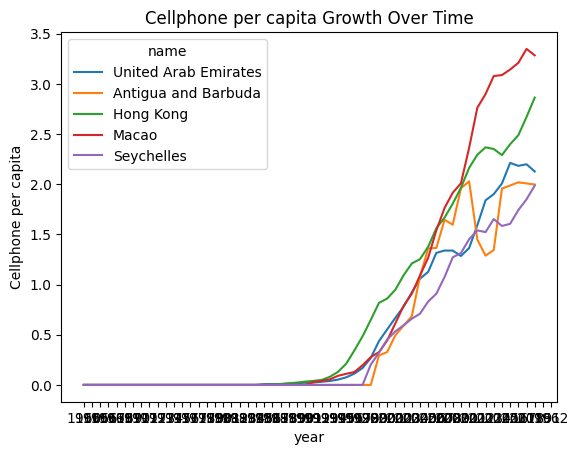

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt


count_5 = merged2[merged2['name'].isin(['Macao','Hong Kong','United Arab Emirates','Antigua and Barbuda','Seychelles'])]
sns.lineplot(data=count_5, x='year', y='cell/pop', hue='name', legend='full')


plt.xlabel('year')
plt.ylabel('Cellphone per capita')
plt.title('Cellphone per capita Growth Over Time')
plt.show()




#### The country with the highest growth is Macao

## SQL

In [24]:
import sqlite3
import pandas as pd

con = sqlite3.connect('user_actions.db')

cur = con.cursor()

# Task 1
# Extract username 
cur.execute("SELECT DISTINCT username FROM user_actions WHERE action = 'signup';")

users = cur.fetchall()
users2 = pd.DataFrame(users, columns=["username"])
print(users2)


   username
0    user34
1    user28
2     user1
3    user24
4    user15
5    user20
6    user18
7    user25
8     user3
9     user9
10   user27
11   user16
12   user17
13    user4
14    user8
15   user13
16   user19
17   user31
18   user10
19   user23
20   user11
21   user33
22   user12
23   user29
24   user21
25    user6
26   user14
27   user30
28    user7
29   user26
30   user22
31    user5
32   user35
33    user2
34   user32


In [41]:
# Find the total number of log entries for each user. Display the user_id, username, and the count of log entries.

#Task 2
# extract user_id, username 
cur.execute("""
SELECT user_id,username, COUNT(*) AS log_count
FROM user_actions
GROUP BY user_id, username;
""")

log_entries = cur.fetchall()
log_entries2 = pd.DataFrame(log_entries, columns=["user_id", "username","log_count"])
print(log_entries2)



    user_id username  log_count
0         1    user1        104
1         2    user2        149
2         3    user3        108
3         4    user4        436
4         5    user5        192
5         6    user6        457
6         7    user7        362
7         8    user8        329
8         9    user9        118
9        10   user10        170
10       11   user11        328
11       12   user12        209
12       13   user13        470
13       14   user14        320
14       15   user15         35
15       16   user16        379
16       17   user17        367
17       18   user18        122
18       19   user19         58
19       20   user20        362
20       21   user21        323
21       22   user22        275
22       23   user23        309
23       24   user24        162
24       25   user25        136
25       26   user26        217
26       27   user27        211
27       28   user28         91
28       29   user29         49
29       30   user30        165
30      

In [72]:
# Task 3 Identify users who have both logged in (action = 'login') 
# and signed up (action = 'signup') on the same day. Display the user_id and username.

cur.execute("""
SELECT
    user_id,
    DATE(timestamp) AS action_date,
    SUM(CASE WHEN action = 'login' THEN 1 ELSE 0 END) AS login_count,
    SUM(CASE WHEN action = 'signup' THEN 1 ELSE 0 END) AS signup_count
FROM user_actions
GROUP BY user_id, DATE(timestamp)
HAVING login_count > 0 AND signup_count > 0;
""")

access = cur.fetchall()
access2 = pd.DataFrame(access, columns=["user_id", "Date","login count","signup count"])
print(access2)

   user_id        Date  login count  signup count
0        2  2022-11-05            1             1
1        5  2022-08-19            2             1
2        7  2021-12-19            1             1
3        8  2018-04-15            1             1
4       12  2020-05-07            1             1
5       22  2022-07-27            2             1
6       30  2021-11-15            1             1
7       32  2022-11-28            1             1


#### As can be observed we have 8 users who has logged in and signed up on the same day and their user id can be found in the table above. 

In [75]:
con.close()

## Regex

In [119]:
import re
import pandas
# Open file and read the content
with open('comments.txt', 'r') as file:
    comments = file.readlines()
# Task 1
# initialize empty list
hashtags_per= [] 
      
for comment in comments:
    # Extract hashtags from the comment
    hashtags = re.findall(r"#\w+", comment)
    
    if hashtags: 
        hashtags_per.append(hashtags)          

# Task 2 a
# initialize empty list
comments_with = []  
for comment in comments:
    # Extract comments with two hashtags
    condition = re.findall(r"(?=.*#programming)(?=.*#python)", comment)
    
    if condition: 
        comments_with.append(comment.strip())

# Task 2 b         
match = re.search(r"(?=.*#programming)(?=.*#python)", comments[1])
print(match) # no match


# Convert to pandas for nice presentation
pdhash=pd.DataFrame(hashtags_per, columns=["hashtag",2,3])
print(pdhash.head(15))

pdcomm=pd.DataFrame(comments_with)

print(pdcomm.head())

None
         hashtag            2      3
0   #programming        #tips   None
1        #coding      #python   None
2          #tech        #data   None
3   #programming      #coding   None
4          #data    #analysis   None
5   #programming      #python  #tips
6          #tech  #innovation   None
7        #coding      #python   None
8          #data   #analytics   None
9   #programming        #tips   None
10       #coding      #python   None
11         #tech        #data   None
12  #programming      #coding   None
13         #data    #insights   None
14  #programming      #python  #tips
                                                   0
0   6. "I learned a lot. #programming #python #tips"
1   15. "Well explained. #programming #python #tips"
2  21. "Love the content! #programming #python #t...
3  30. "Inspired by the tips. #programming #pytho...
